In [1]:
import pickle
import time
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
data = np.load('data.npy', allow_pickle=True)
# game_id , resnet(1 x 1024) , vit (1 x 512) , label_name , guess time

Plot of Distribution of Labels

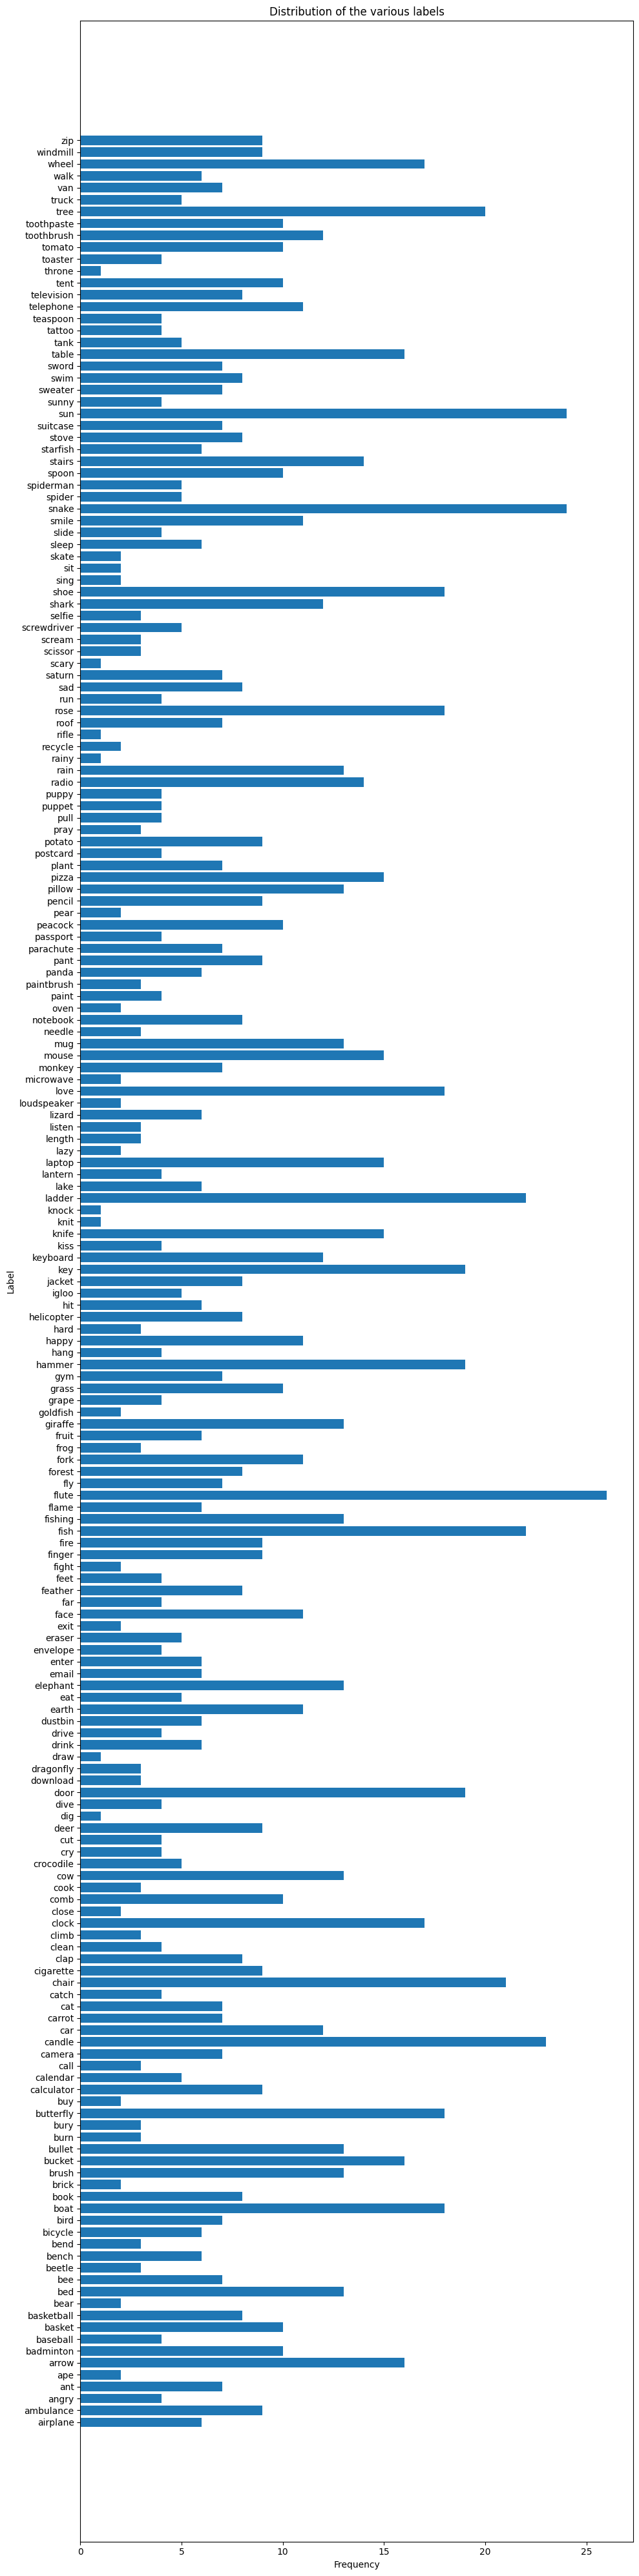

In [2]:
data_labels = np.array(data[:, 3])
values, counts = np.unique(data_labels, return_counts=True)
plt.figure(figsize=(10, 40))
plt.xlabel('Frequency')
plt.ylabel('Label')
plt.title('Distribution of the various labels')
plt.barh(values, counts)
plt.tight_layout()
plt.show()

Initial KNN Model

In [3]:
class KNN:
    def __init__(self, k, encoder_type, metric,ratio=0.8):
        self.k = k
        self.encoder_type = encoder_type
        self.metric = metric
        self.measure = 'mode'
        self.ratio = ratio

    def get_encoder_type(self):
        return self.encoder_type
    def set_encoder_type(self,encoder_type):
        self.encoder_type = encoder_type

    def get_metric(self):
        return self.metric
    def set_metric(self,metric):
        self.metric = metric

    def get_k(self): # get method for K
        return self.k
    def set_k(self,k): # set method for K
        self.k = k

    def get_ratio(self):
        return self.ratio
    def set_ratio(self,ratio):
        self.ratio = ratio


    def get_measure(self, A):
        if self.measure == 'mode':
            unique_values, counts = np.unique(np.array(A), return_counts=True)
            mode_index = np.argmax(counts)
            mode = unique_values[mode_index]
            return mode

    def get_distance(self, E1, E2):
        # print(self.metric)
        if self.metric == 'manhattan':
            return np.sum(np.abs(np.array(E1) - np.array(E2)))
        elif self.metric == 'euclidean':
            return np.sqrt(np.sum(np.square(np.array(E1) - np.array(E2))))
        elif self.metric == 'cosine':
            # print(E1.shape)
            # print(E2.shape)
            return 1-(np.dot(E1,E2)) / (norm(E1) * norm(E2))
        else:
            # print("Unrecognised")
            raise ValueError("Invalid metric")
        
    def fit(self, train_embeddings, train_labels, validate_embeddings, validate_labels):
        self.train_embeddings = train_embeddings
        self.train_labels = train_labels
        self.validate_embeddings = validate_embeddings
        self.validate_labels = validate_labels

    def data_split(self,data):
        self.labels = np.array(data[:, 3])
        self.embeddings = np.array(data[:,1:3])
        resnet = np.array(data[:,1])
        self.resnet = [res[0] for res in resnet]
        self.resnet = np.array(self.resnet)
        vit = np.array(data[:,2])
        self.vit = [v[0] for v in vit]
        self.vit = np.array(self.vit)
        num_total_samples = data.shape[0]
        num_training_samples = int(num_total_samples * self.ratio)
        indices = np.array(range(num_total_samples)) # used to check if unshuffled data is giving same results across users
        np.random.shuffle(indices) # permutes the array [0,....n-1] 
        # indices = np.random.permutation(num_total_samples) 
        self.indices = indices # saving indices
        self.num_training_samples = num_training_samples # saving number of training samples

    def evaluate(self, embeddings, true_labels):
        predicted_labels = self.predict_array(embeddings)
        F1_score = f1_score(true_labels, predicted_labels, average='macro')
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='macro',zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='macro',zero_division=0)
        return F1_score, accuracy, precision, recall

    def train(self, encoder_type):
        if encoder_type == 'vit':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            data_train = self.vit[train_index]
            data_validate = self.vit[validate_index]
            label_train = self.labels[train_index]
            label_validate = self.labels[validate_index]
            self.fit(data_train, label_train, data_validate, label_validate)
        elif encoder_type == 'resnet':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            data_train = self.resnet[train_index]
            data_validate = self.resnet[validate_index]
            label_train = self.labels[train_index]
            label_validate = self.labels[validate_index]
            self.fit(data_train, label_train, data_validate, label_validate)

    def predict_sample(self, E):
        distances = [self.get_distance(embedding, E) for embedding in self.train_embeddings]
        sorted_indices = np.argsort(distances)
        nearest_index = sorted_indices[:self.k]
        nearest_labels = self.train_labels[nearest_index]
        classified_label = self.get_measure(nearest_labels)
        return classified_label

    def predict_array(self, X):
        predictions = [self.predict_sample(embeddings) for embeddings in X]
        return np.array(predictions)
    
    def print_answer(self):
        self.data_split(data)
        self.train(self.encoder_type)  
        F1_score, accuracy, precision, recall = self.evaluate(self.validate_embeddings, self.validate_labels)
        print_data = [['Accuracy',accuracy],['Precision',precision],['Recall',recall],['f1_score',F1_score]]
        df = pd.DataFrame(print_data,columns=['Measure','Value'])
        print(df.to_string(index=False))
    
Initial_KNN = KNN(3,'vit','manhattan')
Initial_KNN.print_answer()
# print(KNN.train_embeddings[0])

  Measure    Value
 Accuracy 0.216667
Precision 0.139975
   Recall 0.128105
 f1_score 0.121278


Hyperparameter Tuning

In [4]:
KNN = KNN(3,'vit','manhattan')
K = [3,5,7,9,11,32,38]
metric = ['manhattan','euclidean']
encoder_type = ['vit']
KNN.data_split(data)
tuples = []
for k in K:
    for metric_type in metric:
        for encoder in encoder_type:
            KNN.set_encoder_type(encoder)
            KNN.set_k(k)
            KNN.set_metric(metric_type)
            KNN.train(KNN.get_encoder_type())
            F1_score, accuracy, precision, recall = KNN.evaluate(KNN.validate_embeddings, KNN.validate_labels)
            tuples.append((accuracy,k,metric_type,encoder))

sorted_tuples = sorted(tuples, key=lambda x: x[0], reverse=True)
best_triplet = sorted_tuples[0]
# print_data = [[' Best Accuracy',best_triplet[0]],['K',best_triplet[1]],['metric_type',best_triplet[2]],['encoder_type',best_triplet[3]]]
# df = pd.DataFrame(print_data,columns=['Measure','Value'])
# print(df)
best_triplets = sorted_tuples[:1]
df = pd.DataFrame(best_triplets, columns=['Best Accuracy', 'k', 'Metric', 'Encoder-Type'])
# Display the DataFrame without the default index column
print(df.to_string(index=False))
print('------------------------------')
top_triplets = sorted_tuples[:20]
# for rank, triplet in enumerate(best_triplets[:20], start=1):
#     print(f"Rank {rank}: k={triplet[1]}, encoder={triplet[2]}, distance metric={triplet[3]}, accuracy={triplet[0]}")
df = pd.DataFrame(top_triplets, columns=['Accuracy', 'k', 'Metric', 'Encoder-Type'])
# Display the DataFrame without the default index column
print(df.to_string(index=False))
given_metric = 'manhattan'
given_encoder_type = 'vit'
k_tuples = sorted(sorted_tuples, key=lambda x: x[1])
filtered_tuples = [(accuracy, k, metric, encoder_type) for accuracy, k, metric, encoder_type in k_tuples
                 if metric == given_metric and encoder_type == given_encoder_type]
filtered_df = pd.DataFrame(filtered_tuples, columns=['Accuracy', 'k', 'Metric', 'Encoder Type'])
print('------------------------------')
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['k'], filtered_df['Accuracy'], marker='o')
plt.title(f'K vs Accuracy for {given_encoder_type} with {given_metric} distance')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Most Optimized KNN Model

In [5]:
class KNN:
    def __init__(self, k, encoder_type, metric,ratio=0.8):
        self.k = k
        self.encoder_type = encoder_type
        self.metric = metric
        self.measure = 'mode'
        self.ratio = ratio

    def get_encoder_type(self):
        return self.encoder_type
    def set_encoder_type(self,encoder_type):
        self.encoder_type = encoder_type

    def get_metric(self):
        return self.metric
    def set_metric(self,metric):
        self.metric = metric

    def get_k(self): # get method for K
        return self.k
    def set_k(self,k): # set method for K
        self.k = k

    def get_ratio(self):
        return self.ratio
    def set_ratio(self,ratio):
        self.ratio = ratio

    def get_measure(self, A):
        if self.measure == 'mode':
            unique_values, counts = np.unique(np.array(A), return_counts=True)
            mode_index = np.argmax(counts)
            mode = unique_values[mode_index]
            return mode

    def get_distance(self, E1, E2):
        # print(self.metric)
        if self.metric == 'manhattan':
            return norm(np.array(E1)-np.array(E2),axis=1,ord=1)
        elif self.metric == 'euclidean':
            return norm(np.array(E1)-np.array(E2),axis=1,ord=2)
        elif self.metric == 'cosine':
            # print(E1.shape)
            # print(E2.shape)
            return 1-(np.dot(np.array(E1),np.array(E2))) / (norm(np.array(E1),axis=1) * norm(np.array(E2)))
        else:
            # print("Unrecognised")
            raise ValueError("Invalid metric")
        
    def fit(self, train_embeddings, train_labels, validate_embeddings, validate_labels):
        self.train_embeddings = train_embeddings
        self.train_labels = train_labels
        self.validate_embeddings = validate_embeddings
        self.validate_labels = validate_labels

    def data_split(self,data):
        self.labels = np.array(data[:, 3])
        self.embeddings = np.array(data[:,1:3])
        resnet = np.array(data[:,1])
        self.resnet = [res[0] for res in resnet]
        self.resnet = np.array(self.resnet)
        vit = np.array(data[:,2])
        self.vit = [v[0] for v in vit]
        self.vit = np.array(self.vit)
        num_total_samples = data.shape[0]
        num_training_samples = int(num_total_samples * self.ratio)
        indices = np.array(range(num_total_samples)) # used to check if unshuffled data is giving same results across users
        # np.random.shuffle(indices) # permutes the array [0,....n-1] 
        # indices = np.random.permutation(num_total_samples) 
        self.indices = indices # saving indices
        self.num_training_samples = num_training_samples # saving number of training samples

    def evaluate(self, embeddings, true_labels):
        predicted_labels = self.predict_array(embeddings)
        F1_score = f1_score(true_labels, predicted_labels, average='macro')
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='macro',zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='macro',zero_division=0)
        return F1_score, accuracy, precision, recall

    def train(self, encoder_type):
        if encoder_type == 'vit':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            data_train = self.vit[train_index]
            data_validate = self.vit[validate_index]
            label_train = self.labels[train_index]
            label_validate = self.labels[validate_index]
            self.fit(data_train, label_train, data_validate, label_validate)
        elif encoder_type == 'resnet':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            data_train = self.resnet[train_index]
            data_validate = self.resnet[validate_index]
            label_train = self.labels[train_index]
            label_validate = self.labels[validate_index]
            self.fit(data_train, label_train, data_validate, label_validate)

    def predict_sample(self, E):
        distances = self.get_distance(self.train_embeddings, E)
        sorted_indices = np.argsort(distances)
        nearest_index = sorted_indices[:self.k]
        nearest_labels = self.train_labels[nearest_index]
        classified_label = self.get_measure(nearest_labels)
        return classified_label

    def predict_array(self, X):
        predictions = [self.predict_sample(embeddings) for embeddings in X]
        return np.array(predictions)
    
    def print_answer(self):
        self.data_split(data)
        self.train(self.encoder_type)  
        F1_score, accuracy, precision, recall = self.evaluate(self.validate_embeddings, self.validate_labels)
        print_data = [['Accuracy',accuracy],['Precision',precision],['Recall',recall],['f1_score',F1_score]]
        df = pd.DataFrame(print_data,columns=['Measure','Value'])
        print(df.to_string(index=False))
    
Optimized_KNN = KNN(3,'vit','manhattan')
Optimized_KNN.print_answer()
# print(KNN.train_embeddings[0])

  Measure    Value
 Accuracy 0.213333
Precision 0.124355
   Recall 0.147739
 f1_score 0.118354


Inference Time vs Model

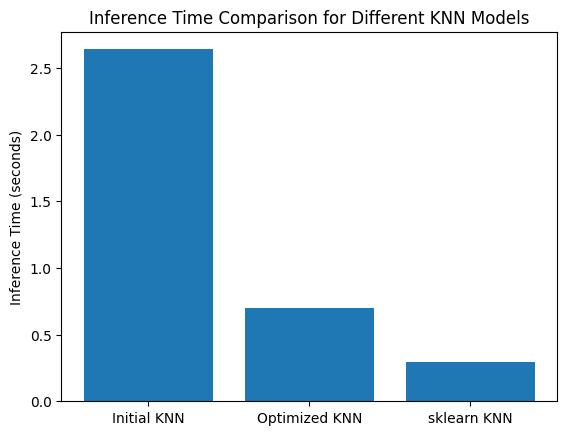

In [6]:
sklearn_knn = KNeighborsClassifier(n_neighbors=3,metric='manhattan')
models = [Initial_KNN,Optimized_KNN]
inference_times = []
for model in models:
    start_time = time.time()
    model.data_split(data)
    model.train(model.encoder_type)  
    F1_score, accuracy, precision, recall = model.evaluate(model.validate_embeddings, model.validate_labels)
    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)
# model_names = ['Initial KNN', 'Best KNN', 'Optimized KNN', 'sklearn KNN']
start_time = time.time()
sklearn_knn.fit(Initial_KNN.train_embeddings,Initial_KNN.train_labels)
sklearn_knn.predict(Initial_KNN.validate_embeddings)
end_time = time.time()
inference_time = end_time - start_time
inference_times.append(inference_time)
model_names = ['Initial KNN','Optimized KNN','sklearn KNN']
plt.bar(model_names, inference_times)
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison for Different KNN Models')
plt.show()

Train_dataset_size vs Inference Time

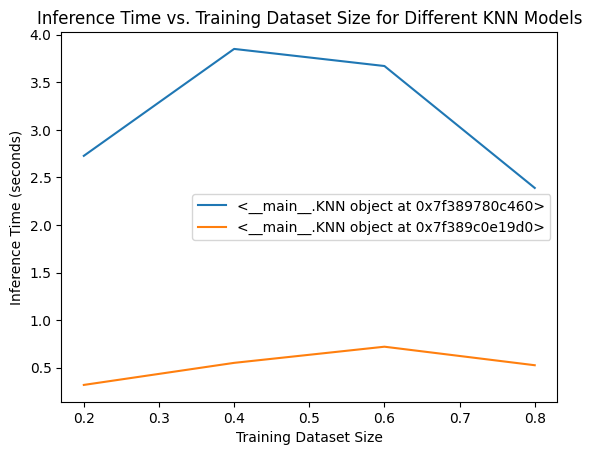

In [7]:
ratios = [0.2,0.4,0.6,0.8]
sklearn_knn = KNeighborsClassifier(n_neighbors=3,metric='manhattan')
models = [Initial_KNN,Optimized_KNN]
inference_times = {model: [] for model in models}
size = data.shape[0]
for ratio in ratios:    
    for model in models:
        start_time = time.time()
        model.set_ratio(ratio)
        model.data_split(data)
        model.train(model.encoder_type)  
        F1_score, accuracy, precision, recall = model.evaluate(model.validate_embeddings, model.validate_labels)
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times[model].append(inference_time)

for model, times in inference_times.items():
    plt.plot(ratios, times, label=model)
    
plt.xlabel('Training Dataset Size')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time vs. Training Dataset Size for Different KNN Models')
plt.legend()
plt.show()